# Bootstrap Filter

In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

## Particle Filter
The particles are like datapoints

In [130]:
class BootstrapFilter(object):
    
    def __init__(self, d, likelihood=(0,1), prior=(-5,5), N=200, \
                 noise = 1., particles=None):
        self.dimension = d
        self.prior = prior
        self.noise = noise
        self.likelihood = likelihood
        
        if particles is not None:
            self.particles = particles
        else:           
            #particles are drawn form a uniform square
            self.particles = np.random.uniform(low=prior[0], high=prior[1],\
                                               size=(N,d))
        self.weights = np.ones(N)
        self.mean = []
        self.var = []
        
    def importantSampling(self, datum):
        a = self.particles.copy()
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(self.particles[i], \
                                               self.likelihood[1]).pdf(datum)        
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        mean = np.average(self.particles, weights=self.weights, axis=0)
        self.mean.append(mean[0])
        #self.var.append(np.average((self.particles-self.mean[-1])**2,\
        #                           weights=self.weights, axis=0))        
        if 1. / np.sum(np.square(self.weights)) < len(self.weights) / 2:
            self.multinomialResampling()
        return self.particles, self.weights
        
    def markovTransition(self, p):
        return p + np.random.normal(0,self.noise)
        
    def multinomialResampling(self):
        N = len(self.weights)
        print 'resampling'
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1
        uniform = np.random.uniform(size=N)
        indexes = np.searchsorted(cumsum, uniform)
        # resample according to indexes
        self.particles = self.particles[indexes]
        self.weights.fill(1.0 / N)
        
        

In [128]:
def printParticleFilter(data, particles, mean, weights=None):
    alpha = 0.01
    for x, y in zip(range(len(data)), particles):
        plt.scatter([x] * len(y), y, color='g', alpha=alpha)
    plt.plot(mean, color='g')
    plt.scatter(range(0,len(data)),data, color='red')
    plt.title('mean of the particle filter')
    plt.show()

In [132]:
def TestData(mean=[4,-4], var=[1,1], n=20, skips=3):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

def runParticleFilter():
    #create data
    data = TestData()
    particles = []
    weights = []
    #feed data to particle Filter
    bs = BootstrapFilter(1)
    for i, d in enumerate(data):
        p, w = bs.importantSampling(d)
        particles.append(p.copy())
        weights.append(w.copy())
    mean = bs.mean
    printParticleFilter(data, particles, mean)
    print mean

resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling
resampling


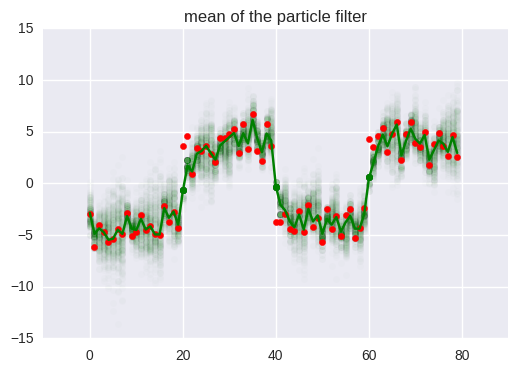

[-2.869648901546479, -4.8877679551555007, -4.3625336401579258, -4.74148822565577, -5.4645919824797158, -5.3606609964905747, -4.4906475104617227, -4.8987234916450744, -3.1723156299771853, -4.3777739916247551, -4.5151595139562737, -3.4428115200722784, -4.4711563944963224, -4.1647789405459337, -4.9472426766765523, -4.9500826252793031, -2.3927551986508049, -3.341113531494627, -2.7301706108428436, -3.9984249372591525, -0.75205464726163807, 1.7152233495604807, 1.1395788545390528, 2.8619198821196976, 3.1186616705822772, 3.6121735447268826, 2.9218965297164852, 2.2844881056350506, 3.6463989162658343, 4.0642899372952401, 4.460041434314709, 4.8625711830374749, 3.6149182741496952, 4.8408185408838085, 3.853493474192474, 6.1382389813001463, 4.3635722530886421, 2.9971856409667401, 4.8122972445929433, 4.1471014209839208, -0.29295360884652855, -2.0919670229779523, -2.618977822316563, -3.6968352467305197, -4.2618388565176959, -3.0228240602448908, -4.4827607519263593, -2.4732506307185775, -3.691446347025

In [133]:
runParticleFilter()

## Particle Filter with discrete state and transition model

In [43]:
class BootstrapFilterDiscreteTransitionModel(object):
    
    def __init__(self, prior, tm, N=5000, noise = 0.1):

        self.tm = np.cumsum(tm, axis=1)
        
        #init particles
        #each particle has: state identifier, Mean, Var
        state = prior[0]
        n = N*state[-1]
        name = np.full((n), 0)
        mean = np.full((n), state[0])\
         + np.random.normal(scale=noise, size=n)
        var = np.full((n), state[1])\
         + np.random.normal(scale=noise, size=n)
        self.particles = np.stack((name,mean,var), axis=-1)
        
        for i, state in enumerate(prior[1:]):
            n = N*state[-1]
            name = np.full((n), i+1)
            mean = np.full((n), state[0])\
             + np.random.normal(scale=noise, size=n)
            var = np.full((n), state[1])\
             + np.random.normal(scale=noise, size=n)
            p = np.stack((name,mean,var), axis=-1)
            self.particles = np.concatenate((self.particles, p))
        print self.particles.shape
        
        
    def importantSampling(self, datum):
        
        for p in self.particles:
            self.markovTransition(p)
            #weightParticle
            #this needs to be saved in an array
            unWeightP = scipy.stats.norm(p[1], p[2]).pdf(datum)
        
        #normalise weights
        self.weights = normWeights(unWeights)
        
    def resample(self):
        #dont know yet
        pass
        
    def markovTransition(self, p):
        r = np.random.rand()
        newState = np.searchsorted(self.tm[p[0]], r)
        p[0] = newState
        #TODO update mean and var of particle to new state
        pass
        